In [2]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.attn_features_artifact import AttentionFeaturesArtifact
from math import sqrt
from torch import Tensor
from omegaconf import OmegaConf

import text3d2video.wandb_util as wbu
import wandb

import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

In [3]:
api = wandb.Api()

attn_type = "0_attn"
attn_type = "self_attn"
attn_type = "extended_attn"

filters = {"tags": attn_type}
run = list(api.runs("romeu/diffusion-3D-features", filters=filters))[0]
conf = OmegaConf.create(run.config)
target_frame_indices = list(conf.cross_frame_attn_experiment.target_frame_indices)

attn_data = wbu.first_logged_artifact_of_type(
    run, AttentionFeaturesArtifact.wandb_artifact_type
)
attn_data = AttentionFeaturesArtifact.from_wandb_artifact(attn_data)

In [9]:
# read attn data
from text3d2video.attention_visualization import AttnFeatures, split_heads

multidict = attn_data.get_features_diskdict()
images = attn_data.get_images()
layer_names = sorted(multidict.key_values("layer"))
time_steps = sorted(multidict.key_values("timestep"))

dec_layers = [layer for layer in layer_names if "up_blocks" in layer]
enc_layers = [layer for layer in layer_names if "down_blocks" in layer]

def get_target_frame_indices(conf, frame_idx):
    attend_to_self = conf.cross_frame_attn_experiment.attend_to_self
    target_frame_indices = conf.cross_frame_attn_experiment.target_frame_indices.copy()
    if attend_to_self:
        target_frame_indices += [frame_idx]
    return target_frame_indices


def get_attn_features(layer, time_step):
    identifier = {"layer": layer, "timestep": time_step}

    # get queries keys and values
    qrys = multidict[identifier | {"name": "query"}][: len(images)]
    keys = multidict[identifier | {"name": "key"}][: len(images)]
    vals = multidict[identifier | {"name": "value"}][: len(images)]

    qrys_mh = split_heads(qrys)
    keys_mh = split_heads(keys)
    vals_mh = split_heads(vals)

    return AttnFeatures(qrys_mh, keys_mh, vals_mh, int(sqrt(qrys.shape[1])))

In [10]:
layer = dec_layers[-1]
time_step = time_steps[0]

attn_features = get_attn_features(layer, time_step)

keys = attn_features.keys_mh
keys.shape

torch.Size([5, 20480, 8, 40])

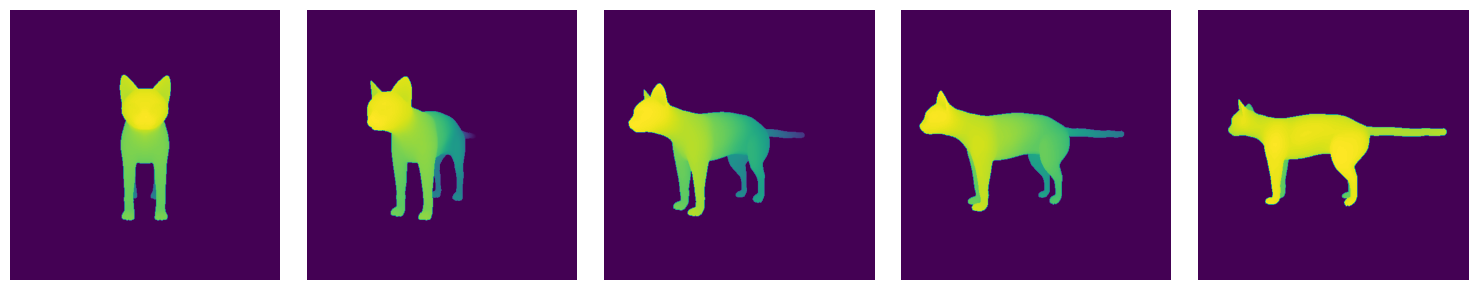

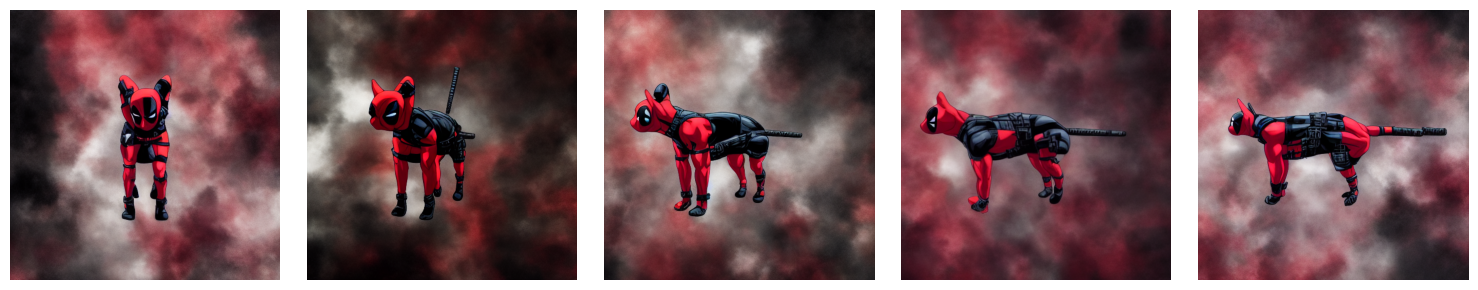

In [11]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

animation = wbu.first_used_artifact_of_type(run, "animation")
animation = AnimationArtifact.from_wandb_artifact(animation)

n_frames = conf.animation.n_frames

frame_nums = animation.frame_nums(n_frames)
cameras = animation.cameras(frame_nums)
meshes = animation.load_frames(frame_nums)

depth_maps = render_depth_map(meshes, cameras)
display_ims(depth_maps, scale=3)
display_ims(images, scale=3)

In [12]:
from einops import einsum
from text3d2video.attention_visualization import get_attn_weights
import torch.nn.functional as F

head_idx = 0
time_step = time_steps[-1]
layer = dec_layers[-1]

attn_features = get_attn_features(layer, time_step)
keys = attn_features.keys_mh[:, :, head_idx, :]
qrys = attn_features.qrys_mh[:, :, head_idx, :]

temperature = 1
device = 'cuda'
attn_scores = einsum(
    qrys.to(device), keys.to(device), "b tq d, b tk d -> b tq tk"
)
attn_weights = F.softmax(
    attn_scores / (temperature * sqrt(qrys.shape[-1])), dim=1
)
attn_weights = attn_weights.cpu().detach()

frame_idx = 1
qry_idx = 100

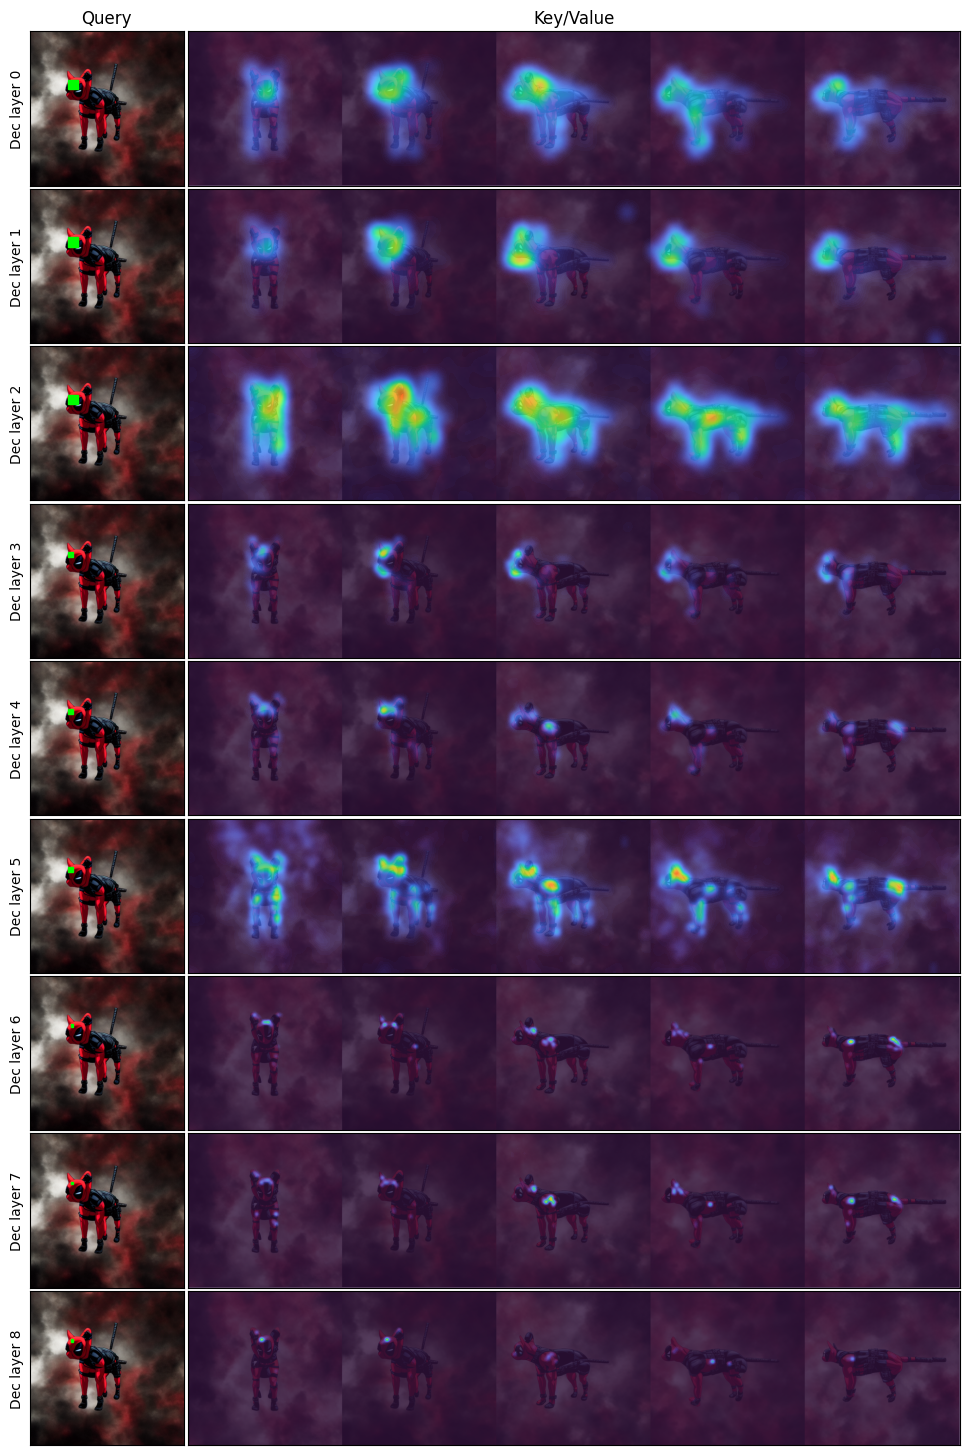

In [13]:
from typing import Callable, List

from text3d2video.attention_visualization import (
    get_attn_weights,
    make_gridspec_figure,
    plot_qry_weights,
)
from text3d2video.sd_feature_extraction import flatten_layer_index, parse_layer_name

def compare_weights(
    layers: List[str],
    time_steps: List[str],
    qry_coords: List[Tensor],
    head_indices: List[int],
    frame_idx: int,
    label_fun: Callable = None,
):
    assert len(layers) == len(time_steps) == len(qry_coords) == len(head_indices)

    target_frame_indices = get_target_frame_indices(conf, frame_idx)

    n_rows = len(layers)
    height_ratios = [1] * n_rows
    width_ratios = [1, len(target_frame_indices)]

    fig, gs = make_gridspec_figure(n_rows, 2, width_ratios, height_ratios)

    for i in range(n_rows):
        layer = layers[i]
        time_step = time_steps[i]
        qry_coord = qry_coords[i]
        head_idx = head_indices[i]

        attn_features = get_attn_features(layer, time_step)
        attn_weights = get_attn_weights(attn_features, head_idx=head_idx)

        ax_qry = fig.add_subplot(gs[i, 0])
        ax_val = fig.add_subplot(gs[i, 1])

        plot_qry_weights(
            ax_qry,
            ax_val,
            attn_features,
            attn_weights,
            qry_coord,
            frame_idx,
            target_frame_indices,
            images,
        )

        if i == 0:
            ax_qry.set_title("Query")
            ax_val.set_title("Key/Value")

        if label_fun:
            label = label_fun(layer, time_step, qry_coord, head_idx)
            ax_qry.set_ylabel(label)

        for ax in [ax_qry, ax_val]:
            ax.set_xticks([])
            ax.set_yticks([])


frame_idx = 1
head_idx = 0
time_step = time_steps[-1]
coord_red = Tensor([0.28, 0.32])
coord_black = Tensor([0.41, 0.42])
layer = dec_layers[-1]

fig_layers = dec_layers
n = len(fig_layers)

fig_coords = [coord_red] * n
fig_time_steps = [time_step] * n
fig_head_indices = [head_idx] * n


def label_fun(layer, time_step, coord, head_idx):
    layer_dict = parse_layer_name(layer)
    block_type = layer_dict["block_type"]
    flat_idx = flatten_layer_index(layer_dict)

    if block_type == "up_blocks":
        block_type_str = "Dec"
    elif block_type == "down_blocks":
        block_type_str = "Enc"
    elif block_type == "mid_block":
        block_type_str = "Mid"

    label = f"{block_type_str} layer {flat_idx}"

    return label

compare_weights(
    fig_layers,
    fig_time_steps,
    fig_coords,
    fig_head_indices,
    frame_idx,
    label_fun=label_fun,
)

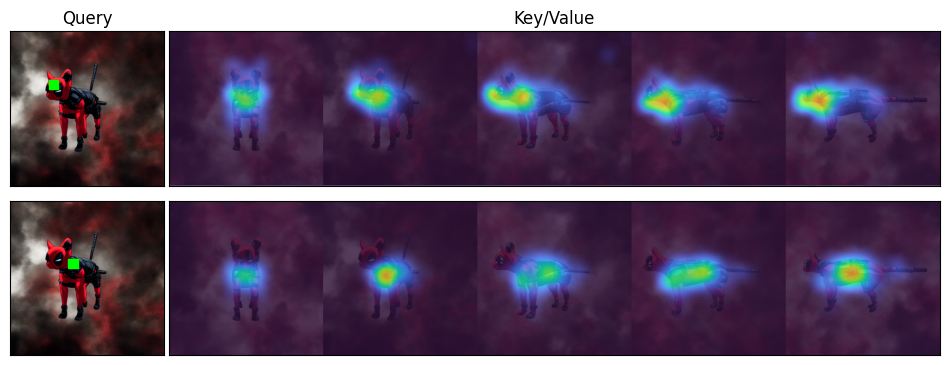

In [14]:
frame_idx = 1
head_idx = 2
time_step = time_steps[2]
layer = dec_layers[-2]
coord_red = Tensor([0.28, 0.32])
coord_black = Tensor([0.41, 0.42])

fig_coords = [coord_red, coord_black]
n = len(fig_coords)

layer = dec_layers[1]

fig_layers = [layer] * n
fig_time_steps = [time_step] * n
fig_head_indices = [head_idx] * n

def label_fun(layer, time_step, coord, head_idx):
    return ""

label_fun = None

compare_weights(
    fig_layers,
    fig_time_steps,
    fig_coords,
    fig_head_indices,
    frame_idx,
    label_fun=label_fun,
)

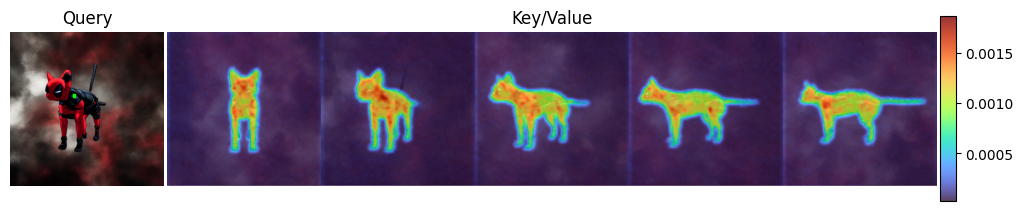

In [29]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, HTMLWriter, ImageMagickWriter

from text3d2video.attention_visualization import (
    coord_to_pixel,
    pixel_coord_flattened,
    reshape_concatenated,
)


def compare_time_steps(
    layer, time_steps, qry_coord, frame_idx=0, head_idx=0, title=None
):
    target_frame_indices = get_target_frame_indices(conf, frame_idx)

    all_weights = []
    for i, t in enumerate(time_steps):
        attn_features = get_attn_features(layer, t)
        attn_weights = get_attn_weights(attn_features, head_idx=head_idx)

        qry_grid_size = (attn_features.layer_res, attn_features.layer_res)
        qry_pix = coord_to_pixel(qry_coord, qry_grid_size)
        qry_pix_1d = pixel_coord_flattened(qry_pix, qry_grid_size)

        weights = attn_weights[frame_idx, qry_pix_1d, :]

        weights_square = reshape_concatenated(
            weights.unsqueeze(-1), layer_res=attn_features.layer_res
        )[0]

        all_weights.append(weights_square)

    height_ratios = [1]
    width_ratios = [1, len(target_frame_indices), 0.1]
    fig, gs = make_gridspec_figure(1, 3, width_ratios, height_ratios)
    ax_qry = fig.add_subplot(gs[0, 0])
    ax_val = fig.add_subplot(gs[0, 1])

    ax_qry.set_title("Query")
    ax_val.set_title("Key/Value")

    for ax in [ax_qry, ax_val]:
        ax.axis("off")

    _, _, _, weights_imshow = plot_qry_weights(
        ax_qry,
        ax_val,
        attn_features,
        attn_weights,
        qry_coord,
        frame_idx,
        target_frame_indices,
        images,
    )
    
    cax = fig.add_subplot(gs[0, 2])
    fig.colorbar(weights_imshow, cax=cax)

    def update(frame_idx):
        weights_imshow.set_data(all_weights[frame_idx])
        weights_imshow.set_clim(
            vmin=all_weights[frame_idx].min(), vmax=all_weights[frame_idx].max()
        )

    anim = FuncAnimation(fig, update, frames=len(time_steps), repeat=True)
    return anim


coord_black = Tensor([0.41, 0.42])

frame_idx = 1
coord = coord_black
head_idx = 0
layer = dec_layers[-1]

anim = compare_time_steps(
    layer, time_steps[0:5], coord, frame_idx=frame_idx, head_idx=head_idx, title="title"
)


gif_writer = ImageMagickWriter(fps=5)
html_writer = HTMLWriter(embed_frames=True)

anim.save("anim.htm", writer=html_writer)
anim.save("anim.gif", writer=gif_writer)